In [ ]:
#following tutorial online. 
import numpy as np
import pandas as pd
#used to grab the stock prices, with yahoo
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
!pip install mpl_finance
from mpl_finance import candlestick2_ohlc

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
start = datetime(2010, 1, 1)
end = datetime(2019,12,28)
ticker = 'SBIN.NS'
data = web.DataReader(ticker,'yahoo',start,end)
data.reset_index(inplace=True)
print(data)

           Date        High         Low  ...       Close      Volume   Adj Close
0    2010-01-04  230.000000  227.500000  ...  229.119995  11031470.0   95.066895
1    2010-01-05  231.000000  228.009995  ...  229.205002  11613740.0   95.102180
2    2010-01-06  231.500000  228.500000  ...  230.580002  14527930.0   95.672699
3    2010-01-07  231.000000  228.110001  ...  229.289993   8576510.0   95.137444
4    2010-01-08  230.389999  228.009995  ...  228.604996  10453820.0   94.853218
...         ...         ...         ...  ...         ...         ...         ...
2454 2019-12-20  339.500000  330.350006  ...  337.850006  51839714.0  337.850006
2455 2019-12-23  338.850006  330.350006  ...  332.399994  30150335.0  332.399994
2456 2019-12-24  334.200012  329.200012  ...  331.450012  21747782.0  331.450012
2457 2019-12-26  333.450012  328.100006  ...  329.850006  24616942.0  329.850006
2458 2019-12-27  338.350006  333.000000  ...  337.250000  33477173.0  337.250000

[2459 rows x 7 columns]


In [ ]:
DATE = 'Date'
OPEN = 'Open'
CLOSE = 'Close'
HIGH = 'High'
LOW = 'Low'
VOLUME = 'Volume'

ROLLING_AVERAGE = 'Rolling Average'
ROLLING_STD = 'Rolling St Dev'
BOLLINGER_TOP = 'Bollinger Top'
BOLLINGER_BOTTOM = 'Bollinger Bottom'

CROSSED_BOLLINGER_BOTTOM_DOWN = 'Crossed Bollinger Bottom Down'
CROSSED_BOLLINGER_BOTTOM_UP = 'Crossed Bollinger Bottom Up'
CROSSED_BOLLINGER_TOP_DOWN = 'Crossed Bollinger Top Down'
CROSSED_BOLLINGER_TOP_UP = 'Crossed Bollinger Top Up'

In [ ]:
class Bollingers:
    
    def __init__(self, df, k, window):
        self.df = df
        self.k = k
        self.window = window
        
        # compute rolling calculations
        self.df[ROLLING_AVERAGE] = self.df[CLOSE].rolling(window=self.window,center=False).mean()
        self.df[ROLLING_STD] = self.df[CLOSE].rolling(window=self.window,center=False).std() 

        # compute bollingers     
        self.df[BOLLINGER_TOP] = self.df.apply(lambda row: self.bollinger('top', row[ROLLING_AVERAGE], row[ROLLING_STD]), axis=1)
        self.df[BOLLINGER_BOTTOM] = self.df.apply(lambda row: self.bollinger('bottom', row[ROLLING_AVERAGE], row[ROLLING_STD]), axis=1)

        # add bools for price crossing bollingers
        self.df[CROSSED_BOLLINGER_BOTTOM_DOWN] = self.df.apply(lambda row: self.crossed_down(row[HIGH], row[CLOSE], row[BOLLINGER_BOTTOM]), axis=1)
        self.df[CROSSED_BOLLINGER_BOTTOM_UP] = self.df.apply(lambda row: self.crossed_up(row[LOW], row[CLOSE], row[BOLLINGER_BOTTOM]), axis=1)
        self.df[CROSSED_BOLLINGER_TOP_DOWN] = self.df.apply(lambda row: self.crossed_down(row[HIGH], row[CLOSE], row[BOLLINGER_TOP]), axis=1)
        self.df[CROSSED_BOLLINGER_TOP_UP] = self.df.apply(lambda row: self.crossed_up(row[LOW], row[CLOSE], row[BOLLINGER_TOP]), axis=1)
        
    def bollinger(self, top_or_bottom, rolling_av, rolling_std):
        if top_or_bottom == 'top':
            return rolling_av + self.k*rolling_std
        elif top_or_bottom == 'bottom':
            return rolling_av - self.k*rolling_std
        else:
            raise ValueError('Expect "top" or "bottom" for top_or_bottom')
    
    def crossed_down(self, High, Close, Bollinger):
        if High >= Bollinger and Close < Bollinger:
            return 1
        else:
            return 0

    def crossed_up(self, Low, Close, Bollinger):
        if Low <= Bollinger and Close > Bollinger:
            return 1
        else:
            return 0
        
    def visualise(self, start_row, end_row):
        df_sample = self.df[start_row:end_row]
        time_range = range(0, len(df_sample[DATE]))

        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111)

        candlestick2_ohlc(ax, 
                          opens=df_sample[OPEN], 
                          closes=df_sample[CLOSE], 
                          highs=df_sample[HIGH],
                          lows=df_sample[LOW],
                          width=1,
                          colorup='g', 
                          colordown='r',
                          alpha=0.75)

        ax.plot(time_range, df_sample[ROLLING_AVERAGE])
        ax.plot(time_range, df_sample[BOLLINGER_TOP])
        ax.plot(time_range, df_sample[BOLLINGER_BOTTOM])

        plt.ylabel("Price")
        plt.xlabel("Date")
        plt.legend()

        plt.show()


In [ ]:
bollingers = Bollingers(data, 3, 20)
bollingers

No handles with labels found to put in legend.


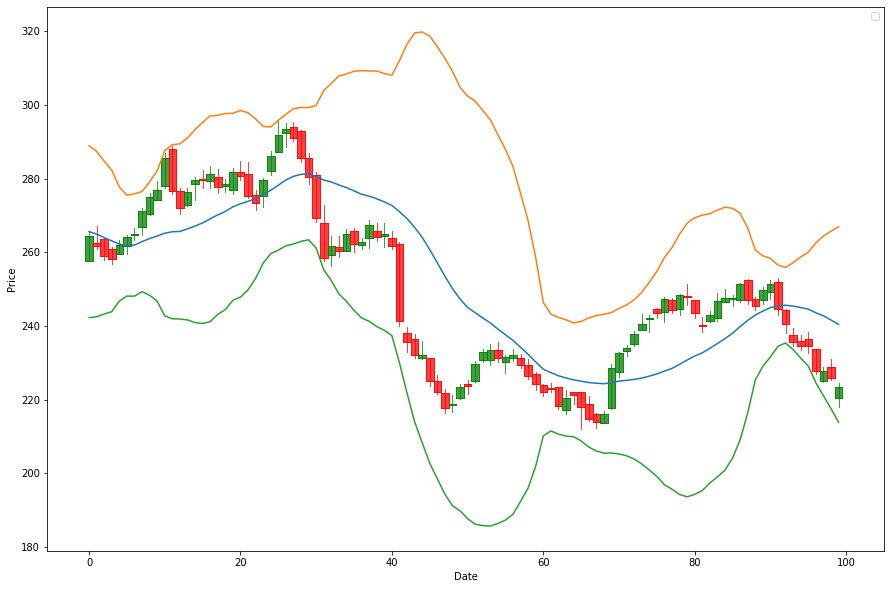

In [ ]:
bollingers.visualise(300,400)

In [ ]:
class Strategy: 
    def __init__(self):
        self.position = 'none'
        self.balance = 0
        self.bought_at = 0
        self.win_loss_array = []
        self.profit_array = []
        
    def long(self, row):
        if self.position == 'none':
            self.position = 'long'
            self.bought_at = row[CLOSE]
        
    def short(self, row):
        if self.position == 'none':
            self.position = 'short'
            self.bought_at = row[CLOSE]
        
    def close_position(self, row):
        
        if self.position == 'short':
            profit_amount = row[CLOSE] - self.bought_at
        elif self.position == 'long':
            profit_amount = self.bought_at - row[CLOSE]
        else:
            profit_amount = 0
            print ('Tried to close a position when none were open')
            
        is_profit = profit_amount > 0
            
        self.balance += profit_amount - 0.000072
        self.profit_array.append(profit_amount)
        self.win_loss_array.append(is_profit)
        self.position = 'none'
        self.bought_at = 0
        
    def print_results(self):
        print ('Final balance: ' + str(self.balance) + ' = ' + str(self.balance*1000) + ' pips')
        print ('Win/Loss ratio: ' + str(sum(self.win_loss_array)/len(self.win_loss_array)*100))
        print ('Biggest win: ' + str(np.amax(self.profit_array)))
        print ('Biggest loss: ' + str(np.amin(self.profit_array)))

In [ ]:
def strategy_1(bollinger_df):
    
    strategy = Strategy()

    for index, row in bollinger_df.iterrows():
        if row[CROSSED_BOLLINGER_BOTTOM_DOWN] == 1 and strategy.position == 'none':
            strategy.long(row)
            
        if row[CROSSED_BOLLINGER_TOP_UP] == 1 and strategy.position == 'none':
            strategy.short(row)

        if row[CROSSED_BOLLINGER_BOTTOM_UP] == 1 and strategy.position == 'long':
            strategy.close_position(row)

        if row[CROSSED_BOLLINGER_TOP_DOWN] == 1 and strategy.position == 'short':
            strategy.close_position(row)
            
    
    return strategy.print_results()

In [ ]:
strategy_1(bollingers.df)

Final balance: -93.11080786914066 = -93110.80786914066 pips
Win/Loss ratio: 36.36363636363637
Biggest win: 44.94000244140625
Biggest loss: -75.64999389648438
